# 0. Imports

In [60]:
import numpy as np
import pandas as pd 
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin

In [61]:
df = pd.read_csv("./playground-series-s4e9/train.csv",index_col='id')
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [62]:
df["brand"].value_counts()[:24]

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
Porsche          10612
Land              9525
Toyota            8850
Lexus             8643
Jeep              6474
Cadillac          4674
RAM               4249
Nissan            3930
Tesla             3738
INFINITI          3276
GMC               3215
Dodge             3133
Mazda             2719
Kia               2497
Lincoln           2423
Subaru            2381
Acura             2282
Honda             2101
Hyundai           2045
Name: count, dtype: int64

In [63]:
df["int_col"].value_counts()[:12]

int_col
Black           107674
Beige            24495
Gray             21204
Brown             5810
Red               5145
White             4743
–                 4527
Jet Black         2398
Ebony             1833
Orange             932
Blue               743
Global Black       628
Name: count, dtype: int64

In [64]:
not_other = df["int_col"].value_counts()[:12].sum()
other = df["int_col"].value_counts()[12:].sum()

print(f"not_other: {not_other}")
print(f"other: {other}")

not_other: 180132
other: 8401


# 1. Column Transformations

In [65]:
def EngineTransformer(X):
	X = X.copy()

	# In case the engine column did not contain the string
	# X['horse_power'] = -1
	# X['tank_size'] = -1
	# X['num_cylinders'] = -1

	X['horse_power'] = X['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
	X['tank_size'] = X['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
	X['num_cylinders'] = X['engine'].str.extract(r'(\d+)\sCylinder').astype(float) 
	   
	# Drop the original 'engine' column
	X.drop('engine', axis=1, inplace=True)
	return X

In [66]:
def TransmissionTransformer(X):
	# Initialize all attributes to False
    X = X.copy()

    X['automatic'] = False
    X['manual'] = False
    X['dual'] = False
    
    # Categorize as 'dual' if it contains 'Dual'
    X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
    
    # Ensure 'dual' is boolean before using ~ operator
    X['dual'] = X['dual'].astype(bool)
    # Categorize as 'automatic' if it contains AT, A/T, CVT, or Automatic (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
    # Categorize as 'manual' if it contains MT, M/T, or Manual (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True

    # Drop the original 'transmission' column
    X.drop('transmission', axis=1, inplace=True)
    
    return X

In [67]:
def ColorTransformer(X):
	X = X.copy()
	# Colors to keep (top 12)
	ext_colors = list(df["ext_col"].value_counts()[:12].index)
	int_colors = list(df["int_col"].value_counts()[:12].index)
	int_colors.remove("–")
	# Categorize as 'other' if not in the top 12 colors
	X.loc[~X['ext_col'].isin(ext_colors), 'ext_col'] = 'other'
	X.loc[~X['int_col'].isin(int_colors), 'int_col'] = 'other'
	
	return X

In [68]:
def BrandTransformer(X):
	X = X.copy()
	# Brands to keep (top 24)
	brands = list(df["brand"].value_counts()[:24].index)
	# Categorize as 'other' if not in the top 24 brands
	X.loc[~X['brand'].isin(brands), 'brand'] = 'other'
	
	return X

In [69]:
def CleanTitleTransformer(X):
    X = X.copy()
    # Change the "Yes" to the boolean True
    X['clean_title'] = X['clean_title'].replace('Yes', True)
    
    return X

In [70]:
def ColumnOrganizer(X):
	X = X.copy()
	X = X.drop(columns=['model'])
	cols = X.columns.tolist()
	cols.append(cols.pop(cols.index('price')))
	X = X[cols]

	return X

In [71]:
def columnTransformer(X):
    X = EngineTransformer(X)
    X = TransmissionTransformer(X)
    X = ColorTransformer(X)
    X = BrandTransformer(X)
    X = CleanTitleTransformer(X)
    X = ColumnOrganizer(X)
    
    return X

In [72]:
df_tranformed = columnTransformer(df)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_26920\771887330.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_26920\771887330.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_26920\771887330.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True


In [73]:
df_tranformed.head(3)

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,
0,other,2007,213000,Gasoline,Yellow,Gray,None reported,True,172.0,1.6,4.0,True,False,False,4200
1,Lincoln,2002,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,True,252.0,3.9,8.0,True,False,False,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,Blue,Gray,None reported,True,320.0,5.3,8.0,True,False,False,13900


# 2. Filling Null Values

# Custom transformations automisation

The following class will preform automizations to the data.
It will be compatible with the scikit learn Pipeline and Transformer objects, making sure the entire pipeline is done automatically on the test data as well.

## Handling Null values in the fuel_type and accident attributes

Since the number of NUlls is very low (3%, 1.5% of the data respectively) we have 2 options:

Option 1 - drop those entries and train the model without them.

Option 2 - Replacing them with another value:
1. The most frequent value in the dataset.
2. A value indicating "unknown".

## Handling Null values in the clean_title attribute

Since the number of NUlls is more significant, we have 2 different options:

Option 1 - drop those entries, since the column would only have one value remaining, it would not contribute to the model training - we would have to drop the attribute entirely.

Option 2 - Replacing them with another value - "No".

We will choose option 2.

In [74]:
def ImputerOne(X):
	X = X.copy()
	
	# Drop null values based on specific conditions
	X = X[X['fuel_type'].notna() & (X['fuel_type'] != 'not supported') & (X['fuel_type'] != '–')]
	X = X[X['accident'].notna()]
	
	# Fill missing values in 'clean_title' column with False
	X['clean_title'] = X['clean_title'].fillna(False)

	# Fill missing values in 'horse_power', 'tank_size', and 'num_cylinders' columns with the mean rounded to the nearest whole number.
	X['horse_power'] = X['horse_power'].fillna(round(X['horse_power'].mean()))

	X['tank_size'] = X['tank_size'].fillna(round(X['tank_size'].mean()))

	X['num_cylinders'] = X['num_cylinders'].fillna(round(X['num_cylinders'].mean()))
	
	return X

In [75]:
def ImputerTwo(X):
	X = X.copy()
	
	X["fuel_type"] = X["fuel_type"].replace('not supported', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace('–', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace(pd.NA, "Gasoline")

	X['accident'] = X['accident'].fillna("Unknown")

	X['clean_title'] = X['clean_title'].fillna(False)

	# Fill missing values in 'horse_power', 'tank_size', and 'num_cylinders' columns with the mean rounded to the nearest whole number.
	X['horse_power'] = X['horse_power'].fillna(round(X['horse_power'].mean()))

	X['tank_size'] = X['tank_size'].fillna(round(X['tank_size'].mean()))

	X['num_cylinders'] = X['num_cylinders'].fillna(round(X['num_cylinders'].mean()))
	
	return X

In [76]:
def preprocessor(X, option):
	X = columnTransformer(X)
	if option == 1:
		X = ImputerOne(X)
	if option == 2:
		X = ImputerTwo(X)
		pass
	# ColorTransformer, etc...

	# The test set does not have the target column
	if 'price' in ((X.columns).to_list()):
		# reorder the df to have price in the rightmost column
		# X = OrderDataframe
		pass
	
	return(X)

In [77]:
df_proc1 = preprocessor(df,1)
df_proc2 = preprocessor(df,2)

C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_26920\771887330.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_26920\771887330.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
C:\Users\Yael Dahari\AppData\Local\Temp\ipykernel_26920\771887330.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True
C:\Users\Yael Dahari\AppData\Local\Tem

In [78]:
print (f'The length of df_proc1 is: {len(df_proc1)}')
print (f'The length of df_proc2 is: {len(df_proc2)}')

The length of df_proc1 is: 180288
The length of df_proc2 is: 188533


In [79]:
df_proc1.head()

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,
0,other,2007,213000,Gasoline,Yellow,Gray,None reported,True,172.0,1.6,4.0,True,False,False,4200
1,Lincoln,2002,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,True,252.0,3.9,8.0,True,False,False,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,Blue,Gray,None reported,True,320.0,5.3,8.0,True,False,False,13900
3,other,2017,19500,Gasoline,Black,Black,None reported,True,420.0,5.0,8.0,False,False,True,45000
4,Mercedes-Benz,2021,7388,Gasoline,Black,Beige,None reported,True,208.0,2.0,4.0,True,False,False,97500


In [80]:
df_proc1.isna().sum()

brand            0
model_year       0
milage           0
fuel_type        0
ext_col          0
int_col          0
accident         0
clean_title      0
horse_power      0
tank_size        0
num_cylinders    0
automatic        0
manual           0
dual             0
price            0
dtype: int64

In [81]:
df_proc1[df_proc1['horse_power'].isna()].head(1)

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,


In [82]:
df.head(9).tail(1)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890


In [83]:
df_proc2.isna().sum()

brand            0
model_year       0
milage           0
fuel_type        0
ext_col          0
int_col          0
accident         0
clean_title      0
horse_power      0
tank_size        0
num_cylinders    0
automatic        0
manual           0
dual             0
price            0
dtype: int64

# 3. Visualizations

In [84]:
df_tranformed.head()

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,
0,other,2007,213000,Gasoline,Yellow,Gray,None reported,True,172.0,1.6,4.0,True,False,False,4200
1,Lincoln,2002,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,True,252.0,3.9,8.0,True,False,False,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,Blue,Gray,None reported,True,320.0,5.3,8.0,True,False,False,13900
3,other,2017,19500,Gasoline,Black,Black,None reported,True,420.0,5.0,8.0,False,False,True,45000
4,Mercedes-Benz,2021,7388,Gasoline,Black,Beige,None reported,True,208.0,2.0,4.0,True,False,False,97500


In [85]:
df_tranformed["price"].value_counts()

price
15000     1920
12000     1459
30000     1280
29000     1228
8500      1204
          ... 
239991      22
269991      22
259991      21
107998      20
45998       19
Name: count, Length: 1569, dtype: int64

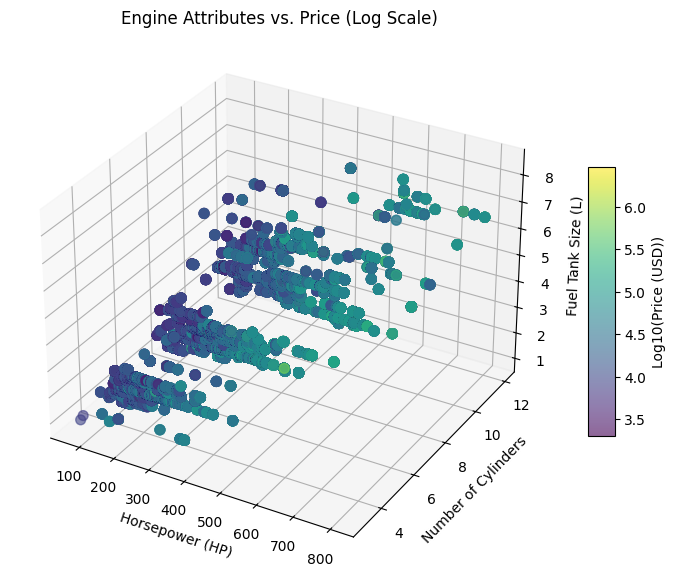

In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

prices_log = np.log10(df_tranformed['price'])

# Scatter plot
sc = ax.scatter(df_tranformed['horse_power'], df_tranformed['num_cylinders'],
				df_tranformed['tank_size'], c=prices_log,
				cmap='viridis', s=50, alpha=0.6)

# Add labels and title
ax.set_title('Engine Attributes vs. Price (Log Scale)')
ax.set_xlabel('Horsepower (HP)')
ax.set_ylabel('Number of Cylinders')
ax.set_zlabel('Fuel Tank Size (L)')

# Add a color bar to represent the price
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Log10(Price (USD))')

plt.show()


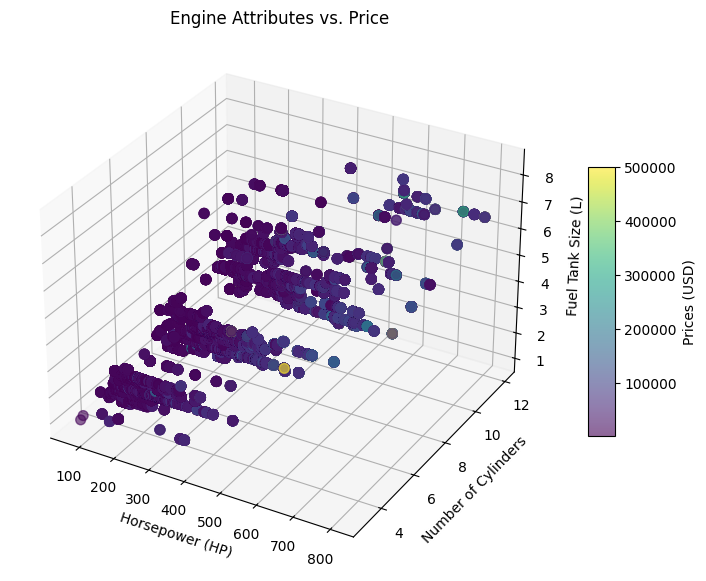

In [87]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

prices_clipped = df_tranformed['price'].clip(0, 500000)

# Scatter plot
sc = ax.scatter(df_tranformed['horse_power'], df_tranformed['num_cylinders'],
				df_tranformed['tank_size'], c=prices_clipped,
				cmap='viridis', s=50, alpha=0.6)

# Add labels and title
ax.set_title('Engine Attributes vs. Price')
ax.set_xlabel('Horsepower (HP)')
ax.set_ylabel('Number of Cylinders')
ax.set_zlabel('Fuel Tank Size (L)')

# Add a color bar to represent the price
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Prices (USD)')

plt.show()


<Axes: >

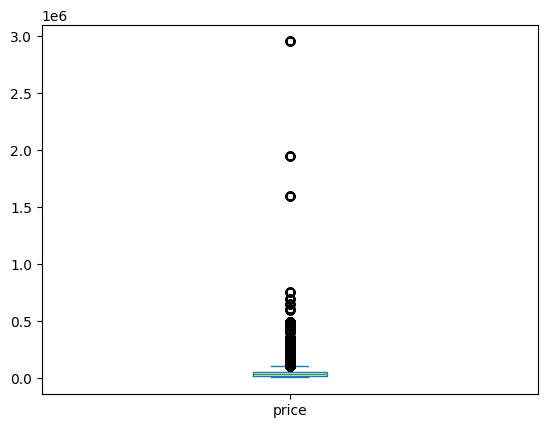

In [88]:
df_tranformed["price"].plot(kind="box")

A correlation heatmap between all the numerical attributes

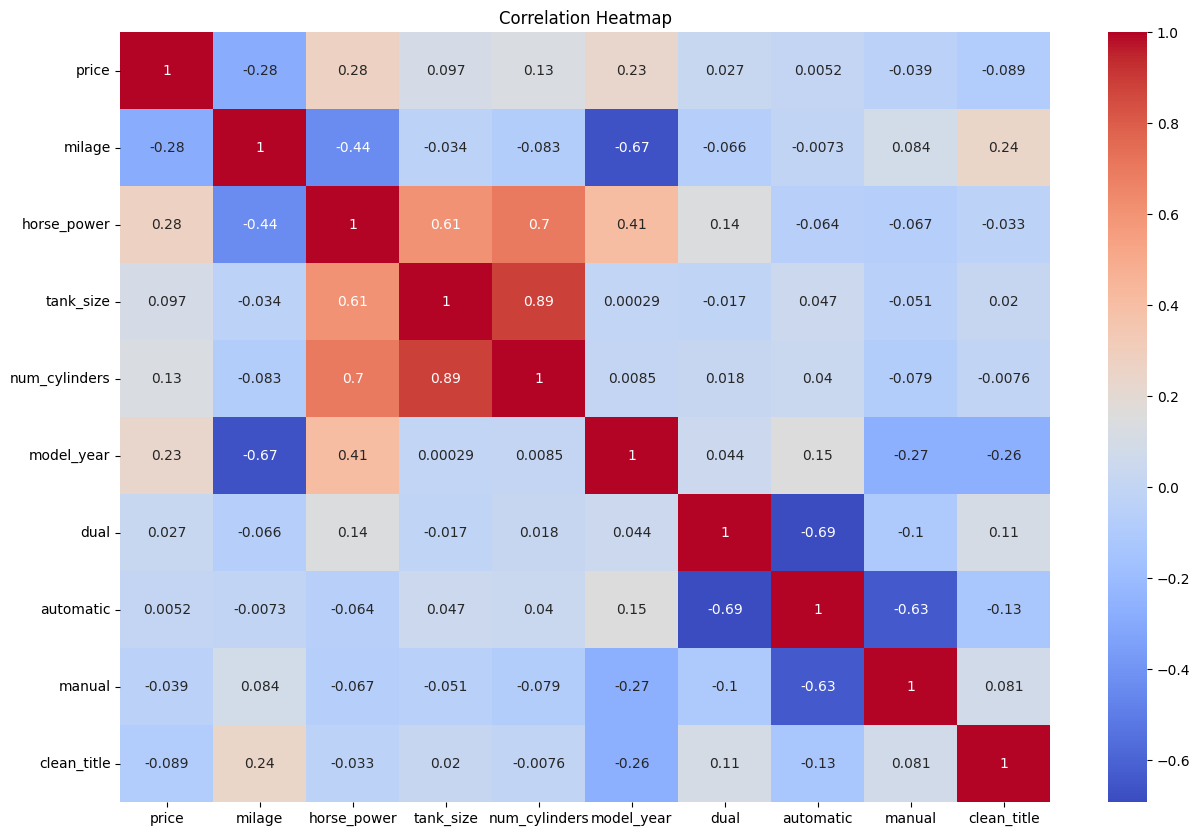

In [137]:
# df_corr = df_tranformed.corr(method="pearson").loc[["price"]]

fig, ax = plt.subplots(figsize=(15,10))
# sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)
numerical_cols = ['price', 'milage', 'horse_power', 'tank_size', 'num_cylinders', 'model_year', 'dual', 'automatic', 'manual', 'clean_title']
corr_matrix = df_tranformed[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

Average Price by Fuel Type

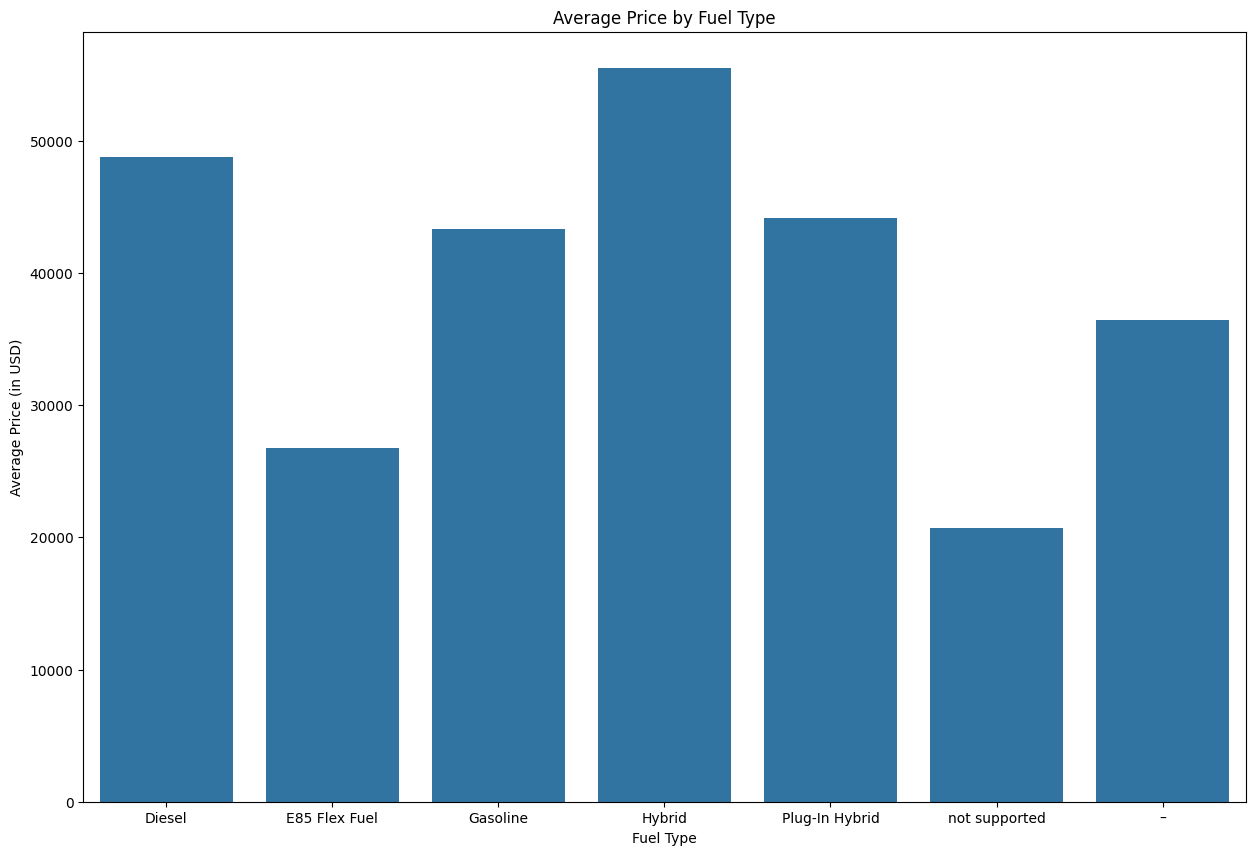

In [93]:
fig, ax = plt.subplots(figsize=(15,10))
avg_price_by_fuel = df_tranformed.groupby('fuel_type')['price'].mean().reset_index()
sns.barplot(data=avg_price_by_fuel, x='fuel_type', y='price', ax=ax)
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price (in USD)')
plt.show()

Violin plot of Fuel Type and Price.
need to change

<Axes: xlabel='fuel_type', ylabel='price'>

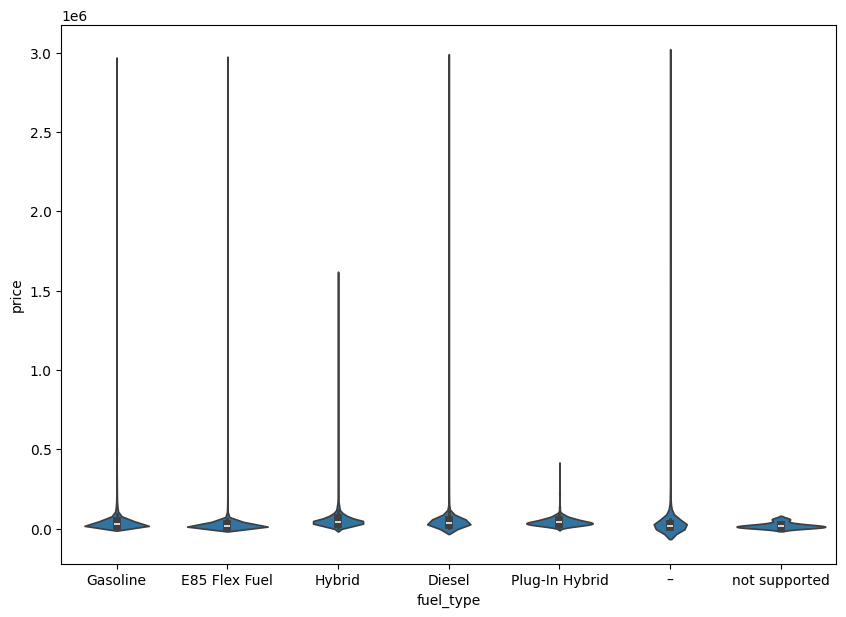

In [105]:
fig, ax = plt.subplots(figsize=(10,7))
sns.violinplot(x='fuel_type', y='price', data=df_tranformed, ax=ax)

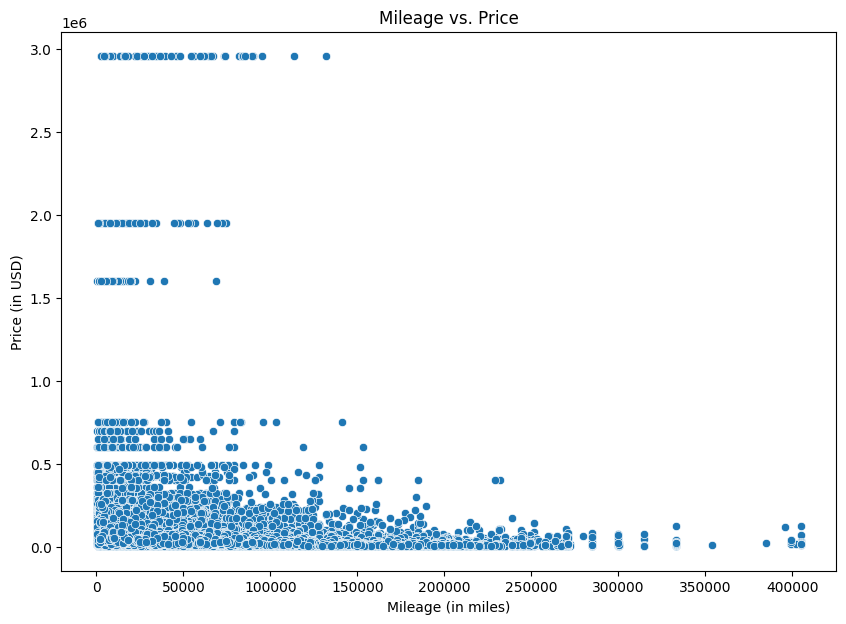

In [116]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_tranformed, x='milage', y='price', ax=ax)
plt.title('Mileage vs. Price')
plt.xlabel('Mileage (in miles)')
plt.ylabel('Price (in USD)')
plt.show()

Average Price by Brand and Accident History

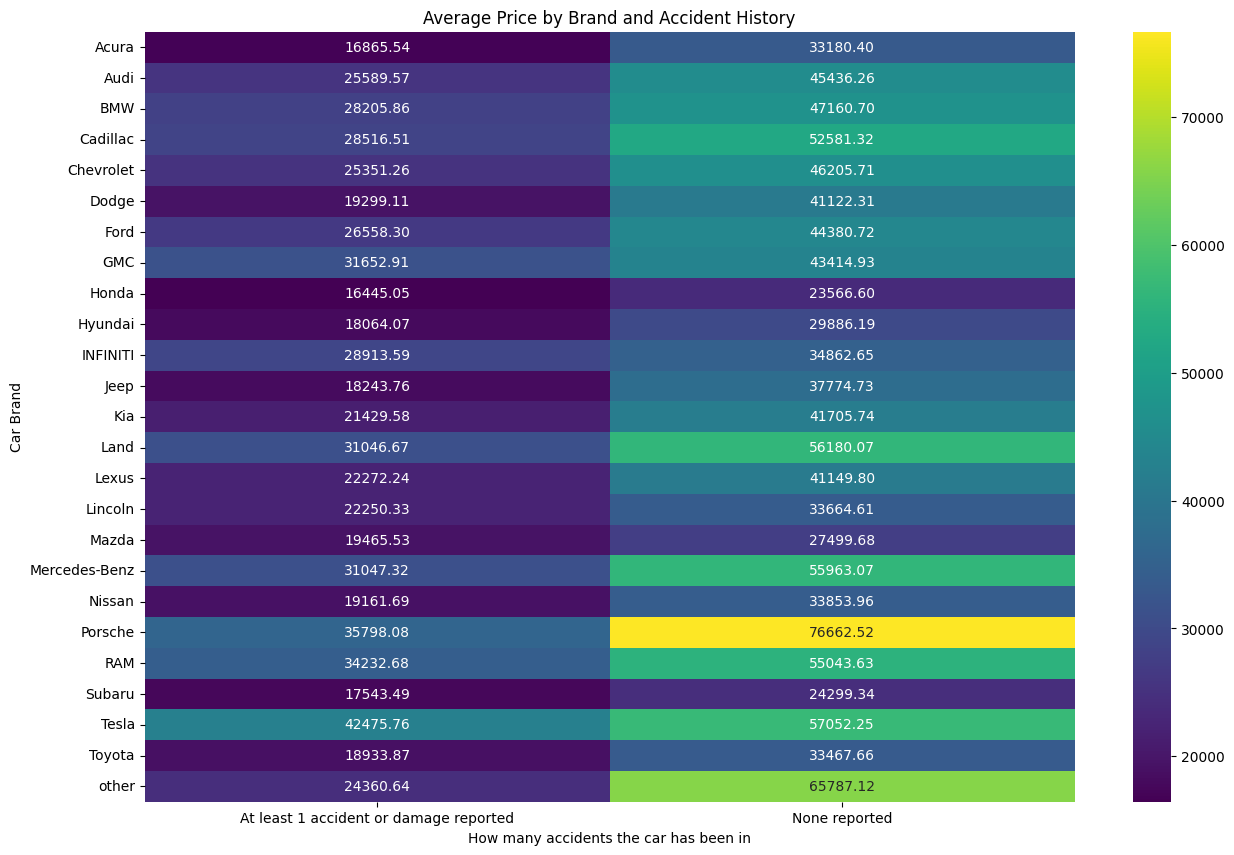

In [133]:
fig, ax = plt.subplots(figsize=(15,10))
# The first is the y axis, the second is the x axis
avg_price_by_transmission = df_tranformed.groupby(['brand', 'accident'])['price'].mean().unstack()
sns.heatmap(avg_price_by_transmission, annot=True, fmt=".2f", cmap='viridis', ax=ax)
plt.title('Average Price by Brand and Accident History')
plt.xlabel('How many accidents the car has been in')
plt.ylabel('Car Brand')
plt.show()

Average Price by Brand and Clean Title

# SUPER INTERESTING !!

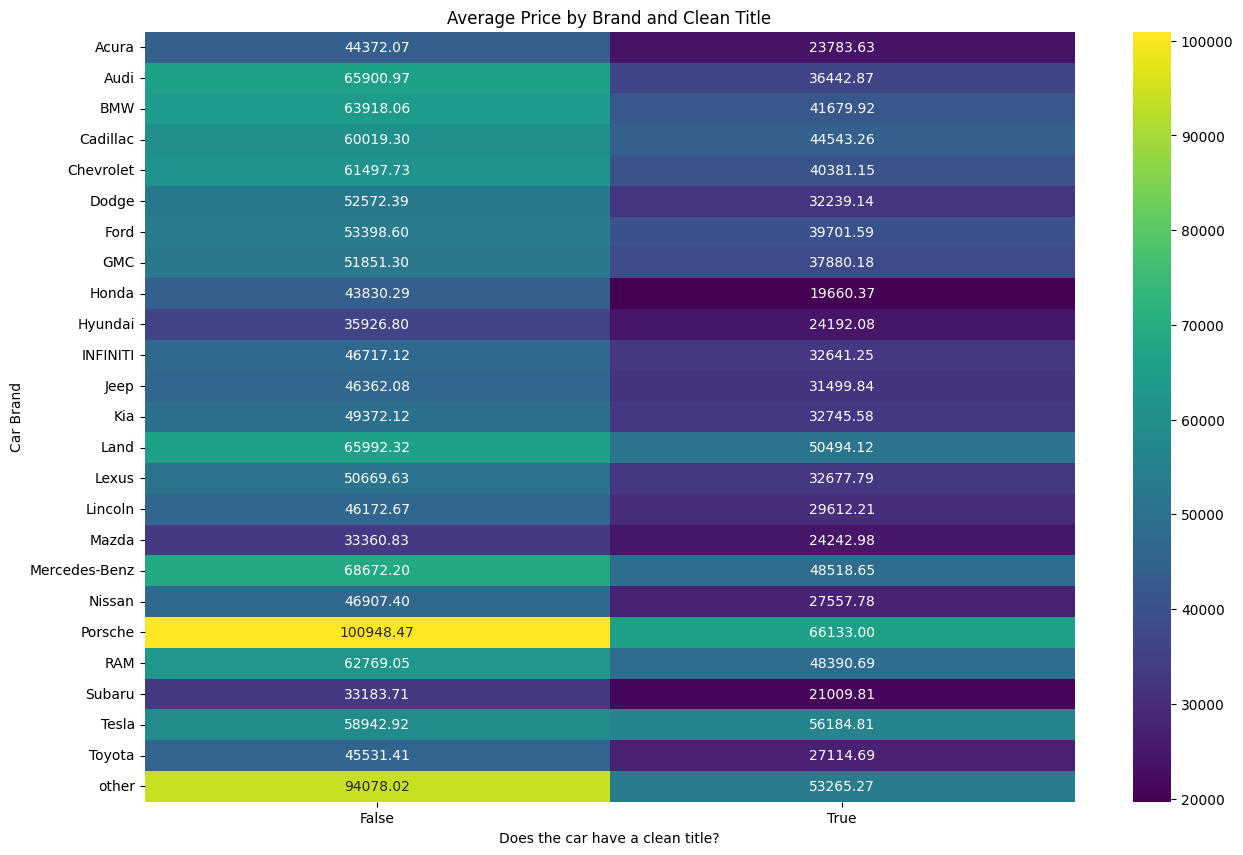

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
# The first is the y axis, the second is the x axis
df_clean = df_tranformed.copy()
df_clean['clean_title'] = df_clean['clean_title'].fillna(False)
avg_price_by_transmission = df_clean.groupby(['brand', 'clean_title'])['price'].mean().unstack()
sns.heatmap(avg_price_by_transmission, annot=True, fmt=".2f", cmap='viridis', ax=ax)
plt.title('Average Price by Brand and Clean Title')
plt.xlabel('Does the car have a clean title?')
plt.ylabel('Car Brand')
plt.show()

Maybe a bit better?

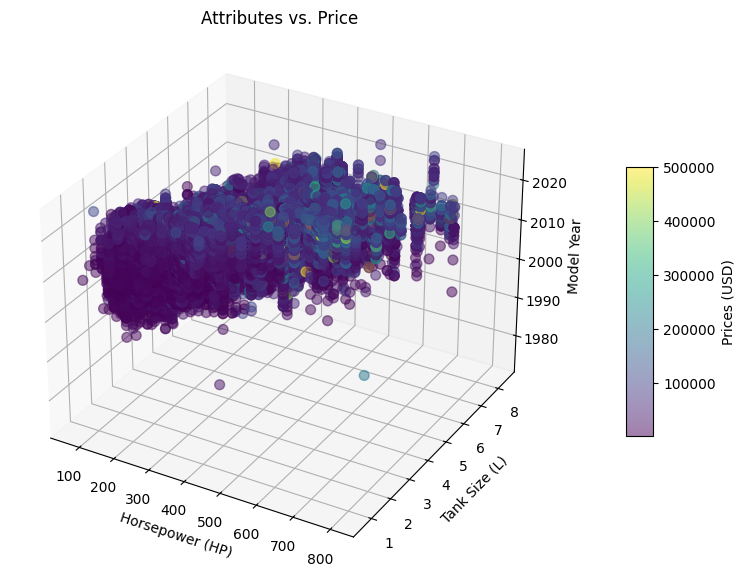

In [176]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111, projection='3d')

prices_clipped = df_tranformed['price'].clip(0, 500000)

# Scatter plot
sc = ax.scatter(df_tranformed['horse_power'], df_tranformed['tank_size'],
				df_tranformed['model_year'], c=prices_clipped,
				cmap='viridis', s=50, alpha=0.5)

# Add labels and title
ax.set_title('Attributes vs. Price')
ax.set_xlabel('Horsepower (HP)')
ax.set_ylabel('Tank Size (L)')
ax.set_zlabel('Model Year')

# Add a color bar to represent the price
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Prices (USD)')

plt.show()


Average Car Price by Model Year

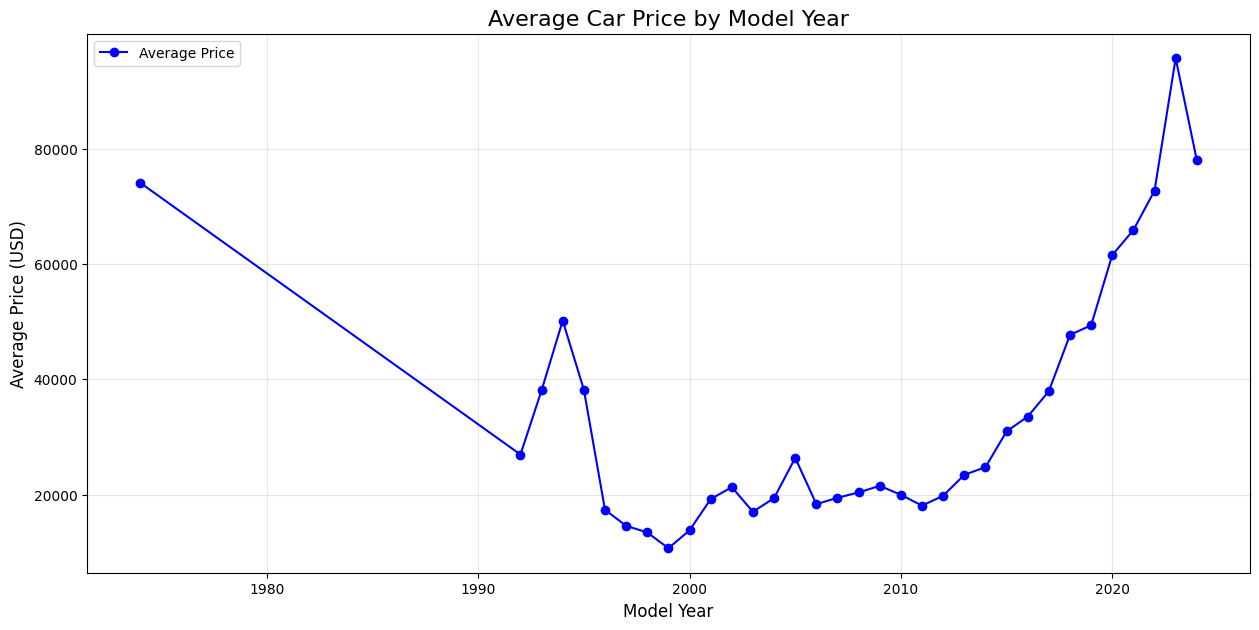

In [155]:
# Group by model year and calculate the mean price
average_prices = df_tranformed.groupby('model_year')['price'].mean()

# Create a line plot
plt.figure(figsize=(15, 7))
plt.plot(average_prices.index, average_prices, marker='o', color='blue', label='Average Price')

# Add titles and labels
plt.title('Average Car Price by Model Year', fontsize=16)
plt.xlabel('Model Year', fontsize=12)
plt.ylabel('Average Price (USD)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Distribution of Car Prices by Model Year Intervals using LOG

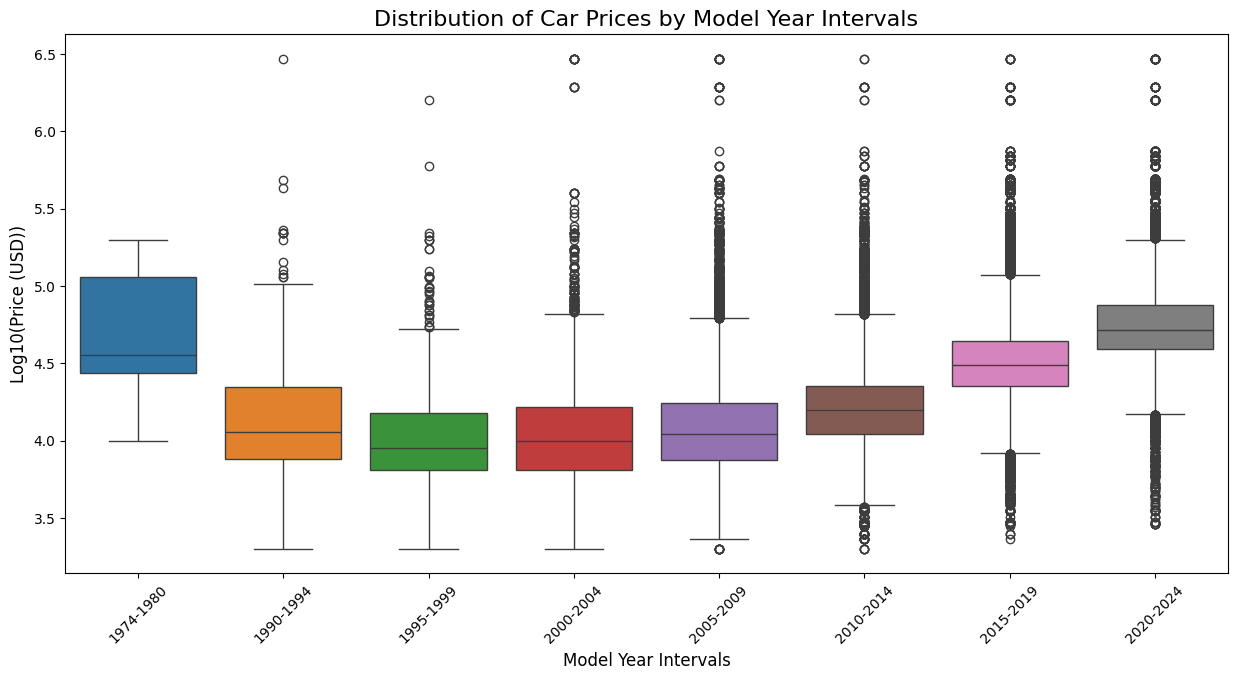

In [171]:
# Define the intervals
bins = [1973, 1980, 1994, 1999, 2004, 2009, 2014, 2019, 2024]  # Adjust bins as needed
labels = ["1974-1980", "1990-1994", "1995-1999", "2000-2004", "2005-2009", 
          "2010-2014", "2015-2019", "2020-2024"]

# Add an interval column
df_interval = df_tranformed.copy()
df_interval['year_interval'] = pd.cut(df_interval['model_year'], bins=bins, labels=labels, right=True)

# Clip prices for better visualization
# prices_clipped = df_interval['price'].clip(0, 500000)

prices_log = np.log10(df_interval['price'])

# Create a box plot
plt.figure(figsize=(15, 7))
sns.boxplot(x='year_interval', y=prices_log, data=df_interval, hue='year_interval', legend=False)

# Add titles and labels
plt.title('Distribution of Car Prices by Model Year Intervals', fontsize=16)
plt.xlabel('Model Year Intervals', fontsize=12)
plt.ylabel('Log10(Price (USD))', fontsize=12)
plt.xticks(rotation=45)
plt.show()